In [1]:
import csv
import os
import numpy as np
import seaborn as sns
from implementations import *
import matplotlib.pyplot as plt

In [2]:
def load_csv_data_with_dictreader(data_path, sub_sample=False):
    '''
    Since csv load function in helpers.py is too slow, we implemented faster reader. 
    load_csv_data function need more than 1 hour on EPFL noto server.
    Still the fastest choice is pandas dataframe. I hope you allow pandas for proj 1 next year.
    '''
    def csv_to_np_arrays(file_path):
        with open(file_path, 'r') as f:
            reader = csv.DictReader(f)
            headers = reader.fieldnames            
            data = [list(map(lambda x: float(x) if x else 0.0, row.values())) for row in reader]            
            return np.array(data), headers
        
    y_train_data, _ = csv_to_np_arrays(os.path.join(data_path, "y_train.csv"))
    x_test_data, _ = csv_to_np_arrays(os.path.join(data_path, "x_test.csv"))
    x_train_data, x_headers = csv_to_np_arrays(os.path.join(data_path, "x_train.csv"))
    y_train = y_train_data[:, 1].astype(dtype=int)
    x_train = x_train_data[:, 1:]
    x_test = x_test_data[:, 1:]
    train_ids = x_train_data[:, 0].astype(dtype=int)
    test_ids = x_test_data[:, 0].astype(dtype=int)

    # sub-sample
    if sub_sample:
        y_train = y_train[::50]
        x_train = x_train[::50]
        train_ids = train_ids[::50]
    return x_train, x_test, y_train, train_ids, test_ids, x_headers

In [3]:
x_train, x_test, y_train, train_ids, test_ids, x_headers = load_csv_data_with_dictreader('data')

In [5]:
x_train_stripped, x_test_stripped = remove_empty_columns(x_train, x_test, 0.6)

In [6]:
def evaluate(y_true, y_predict):
    TP = np.sum((y_true == 1) & (y_predict == 1))
    FP = np.sum((y_true == -1) & (y_predict == 1))
    FN = np.sum((y_true == 1) & (y_predict == -1))
    TN = np.sum((y_true == -1) & (y_predict == -1))
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    return accuracy, f1_score

In [7]:
def k_fold_cross_validation(y, tx, k=5):
    fold_size = len(y) // k
    f1_list = []
    acc_list = []
    
    np.random.seed(0)

    for fold_n in range(k):
        print(fold_n)
        start, end = fold_n * fold_size, (fold_n + 1) * fold_size
        tx_test = tx[start:end]
        y_test = y[start:end]
        tx_train = np.vstack([tx[:start], tx[end:]])
        y_train = np.hstack([y[:start], y[end:]])
        
        w, loss = mean_absolute_error_sgd(y, tx, np.zeros(tx.shape[1]), 500, 0.01)        

        y_test_predicted = np.where(tx_test.dot(w) >= 0.9, 1, -1)
        acc, f1 = evaluate(y_test, y_test_predicted)
        acc_list.append(acc)
        f1_list.append(f1)

    return acc_list, f1_list

In [8]:
result_dict = dict()
indices = np.arange(x_train.shape[0])
np.random.seed(0)
np.random.shuffle(indices)

## 1. baseline

In [12]:
train_x_baseline = x_train_stripped[indices]
train_y_baseline = y_train[indices]

In [13]:
acc_list, f1_list = k_fold_cross_validation(train_y_baseline, train_x_baseline)

0
49
99
149
199
249
299
349
399
449
499
1
49
99
149
199
249
299
349
399
449
499
2
49
99
149
199
249
299
349
399
449
499
3
49
99
149
199
249
299
349
399
449
499
4
49
99
149
199
249
299
349
399
449
499


In [14]:
result_dict['baseline'] = (acc_list, f1_list)

In [15]:
np.mean(acc_list), np.std(acc_list), np.mean(f1_list), np.std(f1_list), 

(0.45848507474057937,
 0.37761728564634744,
 0.09633638733293168,
 0.0787029489996042)

## 2. min-max scaling

In [16]:
def min_max_scale(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    denominators = max_vals - min_vals + 1e-10
    scaled_data = (data - min_vals) / denominators
    
    return scaled_data

In [17]:
scaled_x_train = min_max_scale(x_train_stripped)
train_x_scaled = scaled_x_train[indices]
train_y_scaled = y_train[indices]

In [18]:
acc_list, f1_list = k_fold_cross_validation(train_y_scaled, train_x_scaled)

0
49
99
149
199
249
299
349
399
449
499
1
49
99
149
199
249
299
349
399
449
499
2
49
99
149
199
249
299
349
399
449
499
3
49
99
149
199
249
299
349
399
449
499
4
49
99
149
199
249
299
349
399
449
499


In [21]:
result_dict['scaled'] = (acc_list, f1_list)

In [22]:
np.mean(acc_list), np.std(acc_list),np.mean(f1_list), np.std(f1_list)

(0.9116979292059669, 0.0005953995797657183, 0.0, 0.0)

## 3. Standardization

In [23]:
def standardize_data (x_train, x_test):
    x_train_array = x_train.copy()
    for col_idx in range(x_train_array.shape[1]):
        unique_values = np.unique(x_train_array[~np.isnan(x_train_array[:, col_idx]), col_idx])
        if len(unique_values) == 1 and 1 in unique_values:
            x_train_array[np.isnan(x_train_array[:, col_idx]), col_idx] = 0
    x_test_array = x_test.copy()
    for col_idx in range(x_test_array.shape[1]):
        unique_values = np.unique(x_test_array[~np.isnan(x_test_array[:, col_idx]), col_idx])
        if len(unique_values) == 1 and 1 in unique_values:
            x_test_array[np.isnan(x_test_array[:, col_idx]), col_idx] = 0

    mean_x_train = np.nanmean(x_train_array, axis = 0)
    std_x_train = np.nanstd(x_train_array, axis = 0)
    std_x_train += 1e-10
    x_train_standardized = (x_train_array - mean_x_train) / std_x_train
    x_train_standardized[np.isnan(x_train_standardized)] = 0
    x_test_standardized = (x_test_array - mean_x_train) / std_x_train
    x_test_standardized[np.isnan(x_test_standardized)] = 0
    return x_train_standardized, x_test_standardized

In [25]:
x_train_standardized, _ = standardize_data(x_train_stripped, x_test_stripped)

In [26]:
train_x_standard = x_train_standardized[indices]

In [27]:
acc_list, f1_list = k_fold_cross_validation(y_train, train_x_standard)

0
49
99
149
199
249
299
349
399
449
499
1
49
99
149
199
249
299
349
399
449
499
2
49
99
149
199
249
299
349
399
449
499
3
49
99
149
199
249
299
349
399
449
499
4
49
99
149
199
249
299
349
399
449
499


In [28]:
result_dict['standardized'] = (acc_list, f1_list)

In [29]:
np.mean(acc_list), np.std(acc_list),np.mean(f1_list), np.std(f1_list)

(0.665409054200253,
 0.024391096887845604,
 0.13569805026896947,
 0.0031252274945237487)

## 4. Log transform for skewed feature

In [30]:
def skewness(data):
    mean = np.mean(data)
    stddev = np.std(data)    
    skew = np.mean(((data - mean) / stddev) ** 3)
    return skew

def log_transform(arr, epsilon=1e-10):
    return np.log(arr + epsilon)

scaled_x_train = min_max_scale(x_train_stripped)
for i in range(scaled_x_train.shape[1]):
    transformed_col = skewness(scaled_x_train[:, i])
    if np.max(np.abs(transformed_col)) > 1:
        scaled_x_train[:, i] = log_transform(scaled_x_train[:, i])

In [31]:
train_x_transformed = scaled_x_train[indices]

In [32]:
acc_list, f1_list = k_fold_cross_validation(y_train, train_x_transformed)

0
49
99
149
199
249
299
349
399
449
499
1
49
99
149
199
249
299
349
399
449
499
2
49
99
149
199
249
299
349
399
449
499
3
49
99
149
199
249
299
349
399
449
499
4
49
99
149
199
249
299
349
399
449
499


In [33]:
result_dict['log'] = (acc_list, f1_list)

In [34]:
np.mean(acc_list), np.std(acc_list),np.mean(f1_list), np.std(f1_list)

(0.5595258049278498,
 0.2741034767982326,
 0.10956673826737764,
 0.06139086310491573)

## Visualization

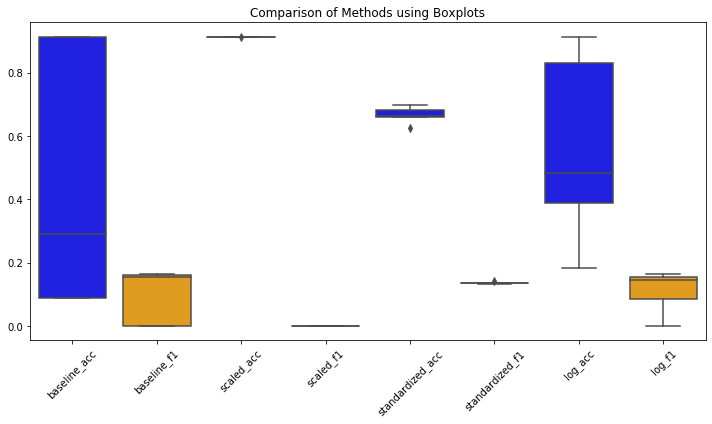

In [35]:
labels = []
acc_data = [x[0] for x in result_dict.values()]
f1_data = [x[1] for x in result_dict.values()]
mixed_data = []
for i, label in enumerate(result_dict.keys()):
    mixed_data.append(acc_data[i])
    mixed_data.append(f1_data[i])
    labels.append(label + "_acc")
    labels.append(label + "_f1")

plt.figure(figsize=(10, 6))
palette = ['blue', 'orange'] * 4 
sns.boxplot(data=mixed_data, palette=palette, showfliers=True)
plt.xticks(np.arange(8), labels, rotation=45)
plt.title("Comparison of Methods using Boxplots")
plt.tight_layout()
plt.show()